In [1]:
# test of global search setup

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from extremasearch.globalmm.globalsearch import MultimodalExtremaSearch
from botorch import fit_gpytorch_mll
import networkx as nx

In [3]:
# setup
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [4]:
def mme_torch(x):
    x = x
    y = torch.zeros(x.shape)
    y += 0.66*(-1.*x + 0.1*torch.sin(30.*x) + torch.exp(-(100.*(x-0.65))**2.))
    y += 0.5 * ( torch.exp(-(100.*(x-0.35))**2.) )
    y += 0.4 * ( torch.exp(-(100.*(x-0.92))**2.) )
    y += 0.73
    return y

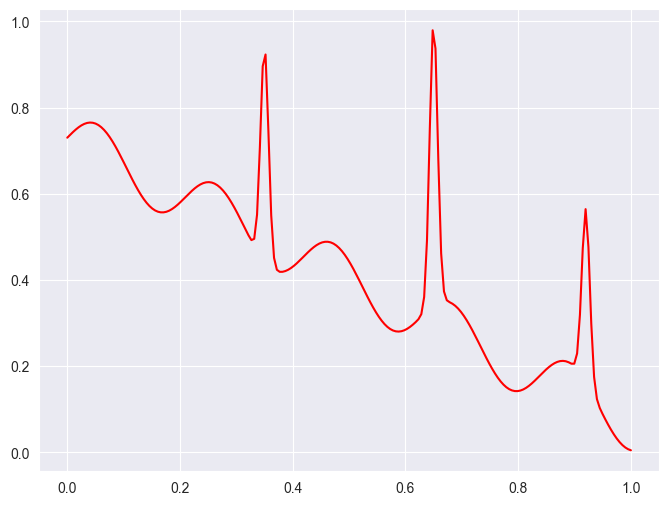

In [5]:
x1 = torch.linspace(0,1.0,200)
y1 = mme_torch(x1)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y1, ax=ax, color='r')
None

In [6]:
def outcome_objective(X):
    """wrapper for the outcome objective function"""
    return mme_torch(X).type_as(X)

In [7]:
test_global_bounds = torch.tensor([0.0, 1.0], dtype=dtype)
test_global_search = MultimodalExtremaSearch(60,test_global_bounds,outcome_objective,)
test_global_search.run_global_search()

Setting up global state
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
Fitting global model
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  0  tead score:  tensor(1.8279, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: Selecting node  0  for split with score  1.8279168725892827
Running partition
PARTITION: Splitting node  0  from  0.0  to  0.5  to  1.0
PARTITION: New node  1  new edge from  0  to  1
PARTITION: New node  2  new edge from  0  to  2
Running subdomain selection
SELECT: For node  1  best x:  0.4207064515431369  best tead:  1.420719260343334
SELECT: For node  2  best x:  0.9995105733341855  best tead:  1.8281762619939284
SELECT: Found  2  as best with score  1.8281762619939284
Running local search
LOCALSEARCH: Running search in node  2
tead
tead
tead
tead
tead
tead
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
turbo
LOCALSEARCH: Completed  17  new evaluations between  9.5003449426803e-06  and

In [8]:
def get_bounds(graph):
    """Get the bounds for each node in a graph to be able to plot them"""
    graph_leaves = [n for n in graph if graph.out_degree[n] == 0]
    bound_list = []
    node_list = []
    for n in graph_leaves:
        # get current leaf node
        current_node = graph.nodes()[n]
        current_state = current_node['data']
        current_bounds = current_state.local_bounds
        node_list.append(n)
        bound_list.append(current_bounds)
    return node_list, bound_list

def get_bounds_all(graph):
    """Get the bounds for each node in a graph to be able to plot them"""
    graph_nodes = [n for n in graph]
    bound_list = []
    node_list = []
    for n in graph_nodes:
        # get current node
        current_node = graph.nodes()[n]
        current_state = current_node['data']
        current_bounds = current_state.local_bounds
        node_list.append(n)
        bound_list.append(current_bounds)
    return node_list, bound_list

In [9]:
test_nodes, test_bounds = get_bounds(test_global_search.global_state.partition_graph)
all_nodes, all_bounds = get_bounds_all(test_global_search.global_state.partition_graph)

In [10]:
from botorch.models.gp_regression import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
def plot_1d_results(mll: ExactMarginalLogLikelihood, model: SingleTaskGP, x_search, y_search, nodes, bnds):
    """Plot 1d results for experiment on multi-modal optimization"""
    fit_gpytorch_mll(mll)
    x_test = torch.linspace(0,1,400)
    f, ax = plt.subplots(1,1, figsize=(8, 6))
    # true objective
    ax.plot(x_test.numpy(), outcome_objective(x_test).numpy(), 'r-', alpha=0.9, label='true objective')
    # final model
    mean_test = model.posterior(x_test).mean.detach().numpy()
    ax.plot(x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
    var_test = model.posterior(x_test).variance.detach().numpy()
    sd_test = np.sqrt(var_test)
    upper_test = mean_test + 2.0*sd_test
    lower_test = mean_test - 2.0*sd_test
    ax.fill_between(x_test.numpy(), lower_test.squeeze(), upper_test.squeeze(), color='b', alpha=0.3, label=r'surrogate 2$\sigma$')
    # training points
    ax.plot(x_search.numpy()[0:10], y_search[0:10].numpy(), '.', color='tab:orange', label='initial data')
    ax.plot(x_search.numpy()[10:], y_search[10:].numpy(), '.', color='g', label='bo data')
    # partitions
    for n, b in zip(nodes, bnds):
        ax.plot([b[0].numpy(), b[0].numpy()], [0, 1], 'k-')
    ax.legend()

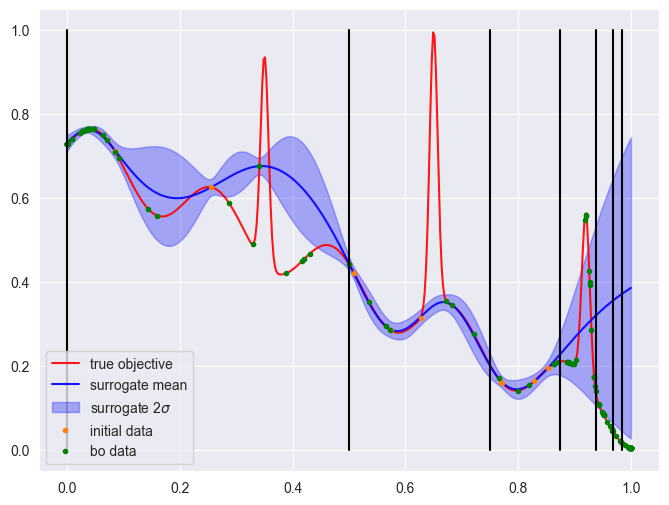

In [11]:
plot_1d_results(test_global_search.global_state.global_mll, test_global_search.global_state.global_model,
                 test_global_search.global_state.x_global, test_global_search.global_state.y_global,
                 test_nodes, test_bounds)

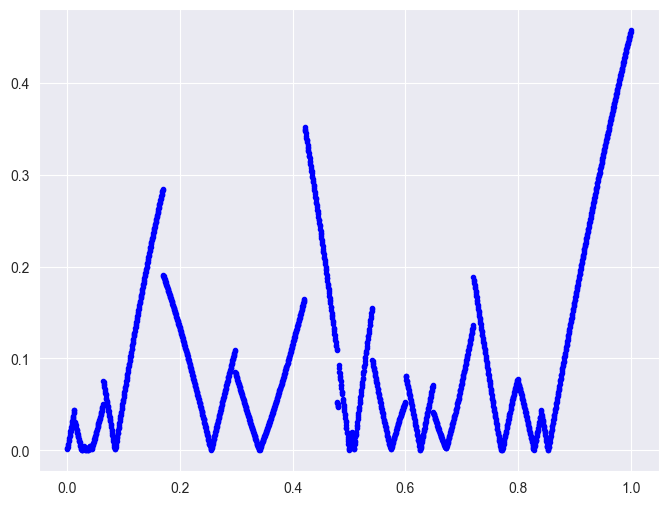

In [12]:
test_x_cand = test_global_search.global_state.x_global_candidates
test_tead_scores = test_global_search.global_state.tead_global_scores

f, ax = plt.subplots(1,1, figsize=(8, 6))
ax.plot(test_x_cand.detach().numpy(), test_tead_scores.detach().numpy(), '.', color='b', label='tead scores')

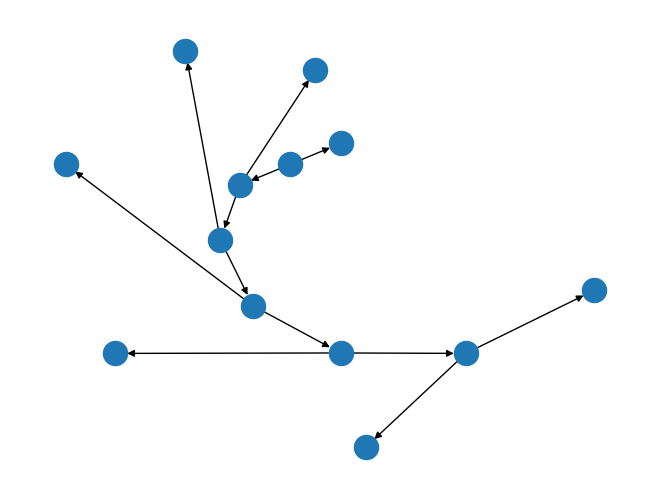

In [13]:
import networkx as nx
G = test_global_search.global_state.partition_graph
pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
nx.draw(G, pos, with_labels=False)

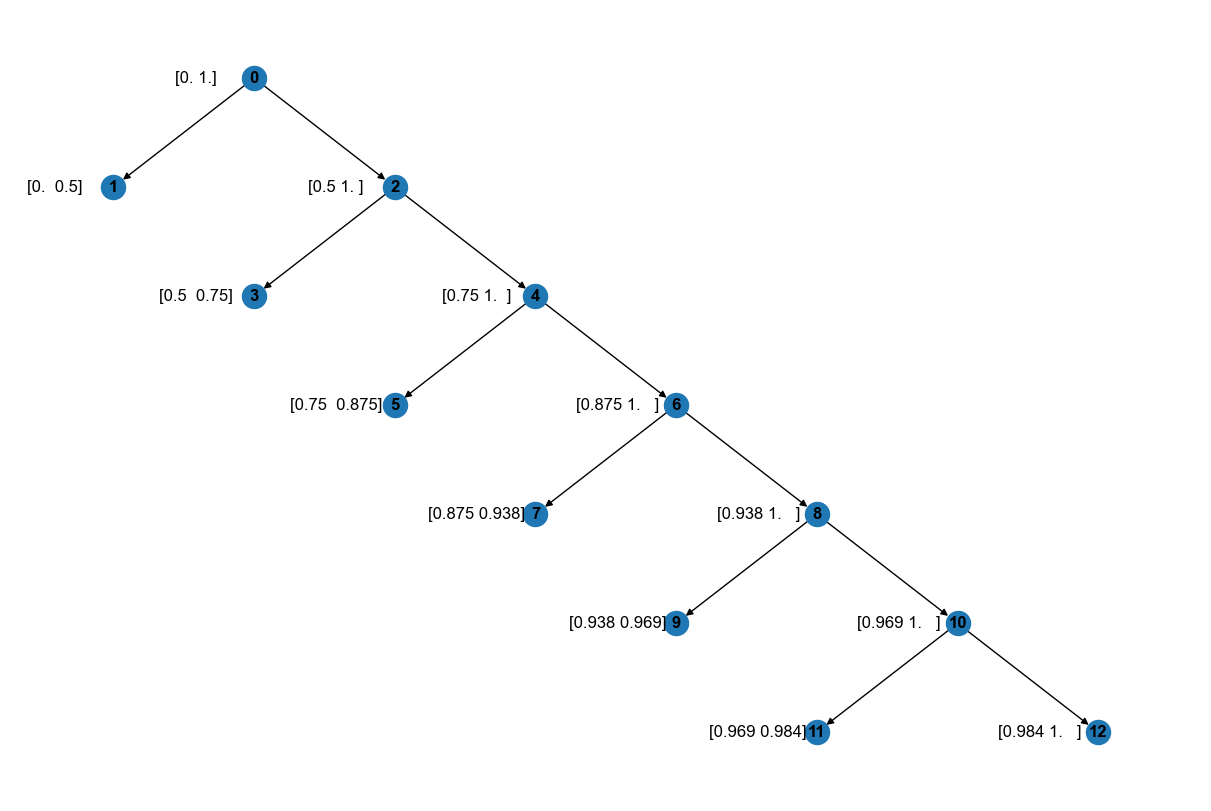

In [17]:
import pydot
import networkx as nx

T = test_global_search.global_state.partition_graph
pos = nx.nx_agraph.graphviz_layout(T, prog="dot")

pos_attrs = {}
for node, coords in pos.items():
    pos_attrs[node] = (coords[0]-15, coords[1])
custom_node_attrs = {}
for node, attrs in zip(all_nodes, all_bounds):
    custom_node_attrs[node] = str(attrs.numpy().round(decimals=3))

f, ax = plt.subplots(1,1, figsize=(12, 8), constrained_layout=True)
nx.draw(T, pos, with_labels=True, font_weight='bold', ax=ax)
nx.draw_networkx_labels(T, pos_attrs, labels=custom_node_attrs, ax=ax)
plt.show()

In [15]:
for node, attrs in zip(all_nodes, all_bounds):
    custom_node_attrs[node] = str(attrs.numpy().round(decimals=3))
    print(custom_node_attrs)

{0: '[0. 1.]', 1: '[0.  0.5]', 2: '[0.5 1. ]', 3: '[0.5  0.75]', 4: '[0.75 1.  ]', 5: '[0.75  0.875]', 6: '[0.875 1.   ]', 7: '[0.875 0.938]', 8: '[0.938 1.   ]', 9: '[0.938 0.969]', 10: '[0.969 1.   ]', 11: '[0.969 0.984]', 12: '[0.984 1.   ]'}
{0: '[0. 1.]', 1: '[0.  0.5]', 2: '[0.5 1. ]', 3: '[0.5  0.75]', 4: '[0.75 1.  ]', 5: '[0.75  0.875]', 6: '[0.875 1.   ]', 7: '[0.875 0.938]', 8: '[0.938 1.   ]', 9: '[0.938 0.969]', 10: '[0.969 1.   ]', 11: '[0.969 0.984]', 12: '[0.984 1.   ]'}
{0: '[0. 1.]', 1: '[0.  0.5]', 2: '[0.5 1. ]', 3: '[0.5  0.75]', 4: '[0.75 1.  ]', 5: '[0.75  0.875]', 6: '[0.875 1.   ]', 7: '[0.875 0.938]', 8: '[0.938 1.   ]', 9: '[0.938 0.969]', 10: '[0.969 1.   ]', 11: '[0.969 0.984]', 12: '[0.984 1.   ]'}
{0: '[0. 1.]', 1: '[0.  0.5]', 2: '[0.5 1. ]', 3: '[0.5  0.75]', 4: '[0.75 1.  ]', 5: '[0.75  0.875]', 6: '[0.875 1.   ]', 7: '[0.875 0.938]', 8: '[0.938 1.   ]', 9: '[0.938 0.969]', 10: '[0.969 1.   ]', 11: '[0.969 0.984]', 12: '[0.984 1.   ]'}
{0: '[0. 1.]', 1

In [16]:
T.nodes()[0].keys()

dict_keys(['data', 'search', 'cands', 'preselect'])